## Домашняя работа №2

## Выбор датасета
Я решил выбрать датасет "scikit-learn/auto-mpg" (https://huggingface.co/datasets/scikit-learn/auto-mpg)

In [44]:
!pip install -q datasets seaborn pandas matplotlib scikit-learn numpy

from datasets import load_dataset
import pandas as pd

dataset_df = load_dataset("scikit-learn/auto-mpg")["train"].to_pandas()

### 3.1. Подготовка данных
Делаем пайплайн и обрабатываем данные

In [45]:
# Разбили на целевую и признаки
target_column = "mpg"

feature_columns = [
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model year",
    "origin"
]

# Заменил '?' на Nan
dataset_df['horsepower'] = pd.to_numeric(dataset_df['horsepower'], errors='coerce')

numeric_columns = dataset_df.select_dtypes(include="number").columns.tolist()
categorical_columns = dataset_df.select_dtypes(exclude="number").columns.tolist()

print("\nЧисловые признаки:", numeric_columns)
print("Категориальные признаки:", categorical_columns)

feature_numeric_columns = (
    dataset_df[feature_columns]
    .select_dtypes(include="number")
    .columns
    .tolist()
)
# получилось что у нас нет категориальных признаков (так как названия машин все разные решил не брать это в признаки)

# Обрабатываем пропуски
prepared_dataframe_imputed = dataset_df[feature_columns + [target_column]].copy()

for numeric_name in feature_numeric_columns:
    median_value = prepared_dataframe_imputed[numeric_name].median()
    prepared_dataframe_imputed[numeric_name] = prepared_dataframe_imputed[numeric_name].fillna(median_value)
   
dataset_df = prepared_dataframe_imputed

features_matrix = dataset_df[feature_columns].copy()
target_vector = dataset_df[target_column].copy()

# разбиваем на группы
from sklearn.model_selection import train_test_split

x, x_test, y, y_test = train_test_split(
    features_matrix,
    target_vector,
    test_size=0.2,
    train_size=0.8,
    random_state = 42
)
x_train, x_cv, y_train, y_cv = train_test_split(
    x,
    y,
    test_size = 0.25,
    train_size =0.75,
    random_state=42
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("scale_numeric", numeric_transformer, feature_numeric_columns)
    ],
    remainder="drop"
)

# обучили на train
transformed_train = preprocessor.fit_transform(x_train)



Числовые признаки: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
Категориальные признаки: ['car name']


## Строим бейзлайн-модели

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
import numpy as np

mean_baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyRegressor(strategy='mean'))
])

median_baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyRegressor(strategy='median'))
])

mean_baseline.fit(x_train, y_train)
median_baseline.fit(x_train, y_train)

mean_y_pred = mean_baseline.predict(x_cv)
mae = mean_absolute_error(y_cv, mean_y_pred)
rmse = np.sqrt(mean_squared_error(y_cv, mean_y_pred))
r2 = r2_score(y_cv, mean_y_pred)
print(f"  MAE mean: {mae:.3f}")
print(f"  RMSE mean: {rmse:.3f}")
print(f"  R² mean: {r2:.3f}")
    
median_y_pred = median_baseline.predict(x_cv)
mae = mean_absolute_error(y_cv, median_y_pred)
rmse = np.sqrt(mean_squared_error(y_cv, median_y_pred))
r2 = r2_score(y_cv, median_y_pred)
print(f"  MAE median: {mae:.3f}")
print(f"  RMSE median: {rmse:.3f}")
print(f"  R² median: {r2:.3f}")



  MAE mean: 7.235
  RMSE mean: 8.729
  R² mean: -0.026
  MAE median: 7.289
  RMSE median: 8.972
  R² median: -0.084


Результаты моделей примерно одинаковы, но бейзлайн по среднему чуть лучше. В среднем модель ошибается на 7 mpg, что довольно существенно для наших данных. RMSE больше MAE, так эта функция более чувствительная к выбросам (у нас нет выбросов но есть пара наблюдений с кратно большим значением чем среднее).

### 3.3. Обучение линейной модели

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linear_model.fit(x_train, y_train)

y_cv_pred = linear_model.predict(x_cv)

linear_mae = mean_absolute_error(y_cv, y_cv_pred)
linear_rmse = np.sqrt(mean_squared_error(y_cv, y_cv_pred))
linear_r2 = r2_score(y_cv, y_cv_pred)

print(f"  MAE: {linear_mae:.3f}")
print(f"  RMSE: {linear_rmse:.3f}")
print(f"  R²: {linear_r2:.3f}")

  MAE: 2.906
  RMSE: 3.897
  R²: 0.796


Линейная регрессия показала результаты лучше, чем бейзлайны. Достаточно маленькая абсолютная ошибка. И R^2 близок к 0.8,  что считается хорошим показателем для модели.

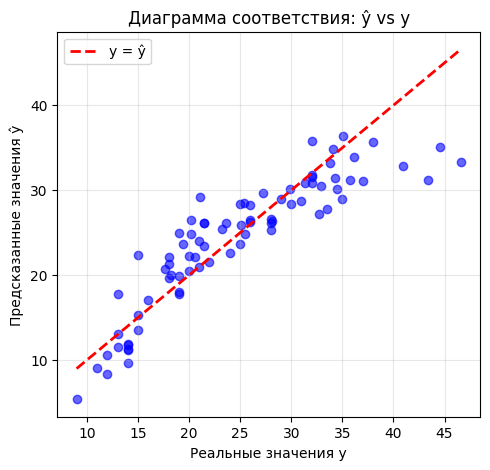

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_cv, y_cv_pred, alpha=0.6, color='blue')
plt.plot([y_cv.min(), y_cv.max()], [y_cv.min(), y_cv.max()], 'r--', lw=2, label='y = ŷ')
plt.xlabel('Реальные значения y')
plt.ylabel('Предсказанные значения ŷ')
plt.title('Диаграмма соответствия: ŷ vs y')
plt.legend()
plt.grid(True, alpha=0.3)

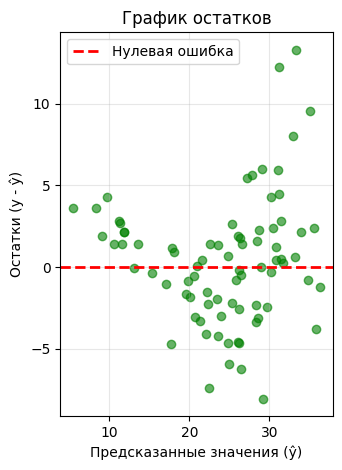

In [49]:
r = y_cv - y_cv_pred

plt.subplot(1, 2, 2)
plt.scatter(y_cv_pred, r, alpha=0.6, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Нулевая ошибка')
plt.xlabel('Предсказанные значения (ŷ)')
plt.ylabel('Остатки (y - ŷ)')
plt.title('График остатков')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

По первой диаграмме видно, что в целом точки собраны около y=x, так что линейность довольно "хорошая", что в целом объясняется высоким показателем R^2=0.796
Выбросов нет, присутсвует несколько наблюдений с кратно большим значением, чем среднее это видно на первом графике (4 точки при y > 40), а также на втором графике присутсвуют точки с отклонением больше 10. 
Гетероскедастичность отсутствует так как по второму графику видно, что остатки распределены вокруг нулевой линии по всему диапазону.

## Обучаем модели с разными функциями потерь
Изначально Linear Regression уже использует MSE, поэтому нам нужно рассчитать только с MAE

In [50]:
from sklearn.linear_model import SGDRegressor
mae_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SGDRegressor(
        loss='epsilon_insensitive',
        epsilon=0,                 
        alpha=0.0001,
        max_iter=10000,
        random_state=42
    ))
])

mae_model.fit(x_train, y_train)
y_cv_mae_pred = mae_model.predict(x_cv)

mae = mean_absolute_error(y_cv, y_cv_mae_pred)
rmse = np.sqrt(mean_squared_error(y_cv, y_cv_mae_pred))
r2 = r2_score(y_cv, y_cv_mae_pred)

print(f"  MAE mae model: {mae:.3f}")
print(f"  RMSE mae model: {rmse:.3f}")
print(f"  R² mae model: {r2:.3f}")

print(f"  MAE mse model: {linear_mae:.3f}")
print(f"  RMSE mse model: {linear_rmse:.3f}")
print(f"  R² mse model: {linear_r2:.3f}")

  MAE mae model: 2.911
  RMSE mae model: 4.211
  R² mae model: 0.761
  MAE mse model: 2.906
  RMSE mse model: 3.897
  R² mse model: 0.796


Модель с MSE показала лучше результат, чем модель с MAE во всем кроме R^2. Что может быть объяснено данными, так как наша выборка не очень большая и у нас нету явных выбросов, что не позволило MAE показать себя. MSE лучше подходит для чистых данных, как в нашем случае.

### Финальная оценка
Лучше всего себя показала модель линейной регрессии с функцией потерь MSE.

In [51]:
y_train_pred = linear_model.predict(x_train)

linear_mae = mean_absolute_error(y_train, y_train_pred)
linear_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
linear_r2 = r2_score(y_train, y_train_pred)

print(f"  MAE train: {linear_mae:.3f}")
print(f"  RMSE train: {linear_rmse:.3f}")
print(f"  R² train: {linear_r2:.3f}")

y_cv_pred = linear_model.predict(x_cv)

linear_mae = mean_absolute_error(y_cv, y_cv_pred)
linear_rmse = np.sqrt(mean_squared_error(y_cv, y_cv_pred))
linear_r2 = r2_score(y_cv, y_cv_pred)

print(f"  MAE cv: {linear_mae:.3f}")
print(f"  RMSE cv: {linear_rmse:.3f}")
print(f"  R² cv: {linear_r2:.3f}")

y_test_pred = linear_model.predict(x_test)

linear_mae = mean_absolute_error(y_test, y_test_pred)
linear_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
linear_r2 = r2_score(y_test, y_test_pred)

print(f"  MAE test: {linear_mae:.3f}")
print(f"  RMSE test: {linear_rmse:.3f}")
print(f"  R² test: {linear_r2:.3f}")

  MAE train: 2.500
  RMSE train: 3.257
  R² train: 0.818
  MAE cv: 2.906
  RMSE cv: 3.897
  R² cv: 0.796
  MAE test: 2.279
  RMSE test: 2.880
  R² test: 0.846


Стабильность модели хорошая, так как на тесте она себя показала лучше в R^2, чем на трейне и на валидационных данных. Это означает, что модель не переобучилась. Средняя ошибка MAE 2,279 mpg, что очень хорошо, так как в среднем данные около 20. Также RMSE лучше, чем на train и вал. данных, что тоже очень хороший показатель.